# Exploring Proteomics Reproducibility with NLP

_Austin Keller - University of Washington - 2019-05-15_

I'm curious about what information is contained in the text descriptions of proteomics projects that can help in automatically reproducing work. Projects such as Param-Medic[1](https://www.ncbi.nlm.nih.gov/pubmed/28263070) attempt to automatically determine run parameters, including species for FASTA selection and experiment type such as TMT or SILAC from the raw data. However, in my experience this doesn't always succeed. I'd like to find out whether common NLP tools can automatically learn experiment run parameters from the archive descriptions, abstracts, or even full papers. This could supplement tools like Param-Medic in ensuring reproducibility and standardizing proteomics computational workflows. It may also help in automatically categorizing the quality of the research done. Param-Medic failing to find paramameters or incorrectly classifying the data can flag the data as poor quality. I don't think this was an intended feature of Param-Medic but it could be a useful one for pruning poor quality data in large-scale studies. I'm hoping an exploration with NLP could also uncover useful heuristics.

There are several archives I could use such as PRIDE, PanoramaPublic, MassIVE, and Chorus. There's also the meta-archive ProteomeXchange. I'm selecting PRIDE for this first investigation. The data is clean and well structured, there's a lot of it (7000+) experiments, and importantly there are long text descriptions that I can access directly through the API.

# Collecting the Raw Data

This page provides an example of the information we can pull directly from PRIDE: https://www.ebi.ac.uk/pride/archive/projects/PXD009005

There are 7000+ such experiments with descriptions and classifications (such as instrument type, experiment type, modifications) that we can try predicting. There are also links to the papers for each experiment, which we _could_ collect and process, but let's hold off on that for now.

Let's get started and pull descriptions and experiment classifications from the PRIDE Archive REST API. It's a simple API and we could write it ourself using `requests` but there's a nice wrapper written by bioservices that appears to be complete.

The URL for the API provides it's own interactive documentation: https://www.ebi.ac.uk/pride/ws/archive/
The relevant code for bioservices, which appears to have all of the functions we want: https://github.com/cokelaer/bioservices/blob/master/src/bioservices/pride.py

In [36]:
import pandas as pd
from bioservices import PRIDE
import sys

In [9]:
pride = PRIDE()

In [17]:
num_projects = pride.get_project_count()
num_projects

7588

In [18]:
pride.get_project_list?

In [24]:
pride.get_project_list(show=10, page=0)[0]

{'accession': 'PXD005994',
 'title': 'Aspergillus fumigatus melanin manipulates the cargo and kinetics of neutrophil-derived extracellular vesicles',
 'projectDescription': 'Neutrophil-derived extracellular vesicles have regained scientif',
 'publicationDate': '2019-05-17',
 'submissionType': 'PARTIAL',
 'numAssays': 0,
 'species': ['Neosartorya fumigata (Aspergillus fumigatus)'],
 'tissues': [],
 'ptmNames': ['iodoacetamide derivatized residue',
  'TMT6plex-126 reporter+balance reagent acylated residue'],
 'instrumentNames': ['Q Exactive'],
 'projectTags': ['Biological', 'Biomedical']}

In [23]:
page_size = 1000
project_list = []

for offset in range(0, num_projects, page_size):
    project_list.extend(pride.get_project_list(show=page_size, page=offset//page_size))
    print(len(project_list))


1000
2000
3000
4000
5000
6000
7000
7588


Great, we now have the full listing of accession numbers, which is what we're after. With these we can pull the experiment page data with full descriptions and classes

In [33]:
len(project_list[0:10])

10

In [41]:
project_full_list = []

for accession in map(lambda x: x['accession'], project_list[0:]):
    project_full_list.append(pride.get_project(accession))
    sys.stdout.write("\r{}/{}".format(len(project_full_list), len(project_list)))

7516/7588

CRITICAL[bioservices:PRIDE]:  HTTPSConnectionPool(host='www.ebi.ac.uk', port=443): Max retries exceeded with url: /pride/ws/archive/project/PRD000066 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='www.ebi.ac.uk', port=443): Read timed out. (read timeout=30)",))
CRITICAL[bioservices:PRIDE]:  Issue. Maybe your current timeout is 30 is not sufficient. 
Consider increasing it with settings.TIMEOUT attribute


7588/7588

In [51]:
# Uh oh, looks like we might have failed transfers

for i, c in enumerate(project_full_list):
    if c is None:
        print(i)

7516


In [53]:
# Yep, let's add those in manually
project_full_list[7516] = pride.get_project(project_list[7516]['accession'])

CRITICAL[bioservices:PRIDE]:  HTTPSConnectionPool(host='www.ebi.ac.uk', port=443): Max retries exceeded with url: /pride/ws/archive/project/PRD000066 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='www.ebi.ac.uk', port=443): Read timed out. (read timeout=30)",))
CRITICAL[bioservices:PRIDE]:  Issue. Maybe your current timeout is 30 is not sufficient. 
Consider increasing it with settings.TIMEOUT attribute


In [56]:
print(project_full_list[7516])
print(project_list[7516])

None
{'accession': 'PRD000066', 'title': 'Quantitative Proteomics Analysis of the Secretory Pathway', 'projectDescription': 'Not available', 'publicationDate': '2009-06-16', 'submissionType': 'PRIDE', 'numAssays': 4090, 'species': ['Rattus norvegicus (Rat)'], 'tissues': [], 'ptmNames': [], 'instrumentNames': ['Not Specified'], 'projectTags': []}


In [61]:
# Nevermind, looks like that project is just no good. Let's remove that project from the list and keep going

In [62]:
import copy
pfl_bak = copy.deepcopy(project_full_list)

In [63]:
pfl_trim = project_full_list[:7516] + project_full_list[7517:]
print(len(pfl_trim))

7587


In [67]:
len(pfl_trim)

7587

In [80]:
# Let's save this data so that we don't have to transfer again
import pickle

with open('raw/PRIDE_projects_raw_download.pkl', 'wb') as f:
    pickle.dump(pfl_trim, f)

In [81]:
with open('raw/PRIDE_projects_raw_download.pkl', 'rb') as f:
    pfl_loaded = pickle.load(f)

print(len(pfl_loaded))

7587


In [82]:
# Now let's try to save it in a more structured format by wrangling it into a pandas dataframe

In [71]:
import pprint

pprint.sorted = lambda x, key=None: x
pprint.pprint(pfl_trim[0])

{'accession': 'PXD005994',
 'title': 'Aspergillus fumigatus melanin manipulates the cargo and kinetics of '
          'neutrophil-derived extracellular vesicles',
 'projectDescription': 'Neutrophil-derived extracellular vesicles have '
                       'regained scientific interest as potent ‘wireless’ '
                       'modulators with pleiotropic effects on the immune '
                       'system. A few studies have addressed their role in the '
                       'context of microbial pathogenesis showing their '
                       'bacteriostatic effects against Staphylococcus aureus '
                       'in vitro and their potential as diagnostic markers in '
                       'the onset of bacterimic sepsis in vivo. Here, we '
                       'provided first insights into the vesicle release '
                       'driven by the clinically relevant pathogenic fungus '
                       'Aspergillus fumigatus that causes invasive inf

                           'OpenMS method a max. retention time difference of '
                           '0.33 min, a max. m/z difference of 10 ppm, a '
                           'q-value threshold of 0.01 and a protein level '
                           'false discovery rate of <0.05 was used. The '
                           'abundance values were normalized based on the '
                           'total peptide amount. Only unique peptides were '
                           'considered for quantification. The significance '
                           'threshold for differential protein regulation was '
                           'set to factor ≥2.0 (up- or down-regulation).',
 'otherOmicsLink': None,
 'numProteins': 0,
 'numPeptides': 0,
 'numSpectra': 0,
 'numUniquePeptides': 0,
 'numIdentifiedSpectra': 0,
 'references': []}


In [96]:
pd.DataFrame(pfl_trim[0:2972])

,accession,dataProcessingProtocol,doi,experimentTypes,instrumentNames,keywords,labHeads,numAssays,numIdentifiedSpectra,numPeptides,...,quantificationMethods,reanalysis,references,sampleProcessingProtocol,species,submissionDate,submissionType,submitter,tissues,title
0,PXD005994,Protein database search and reporter ion quant...,None,[Shotgun proteomics],[Q Exactive],"neutrophils, antifungal extracellular vesicles...","[{'title': 'Dr', 'firstName': 'Axel A.', 'last...",0,0,0,...,[TMT],None,[],Purified ectosomes from 20 different donors we...,[Neosartorya fumigata (Aspergillus fumigatus)],2017-03-01,PARTIAL,"{'title': 'Dr', 'firstName': 'Thomas', 'lastNa...",[],Aspergillus fumigatus melanin manipulates the ...
1,PXD011176,"Protein sample were loaded onto SDS-PAGE gel, ...",None,[Shotgun proteomics],[Q Exactive],"Pseudostuga, embryonal mass, non-embryogenic c...","[{'title': 'Dr', 'firstName': 'Stephane', 'las...",0,0,0,...,[Label free],None,"[{'desc': 'Gautier F, Label P, Eliášová K, Lep...",Soluble proteins extracts were prepared from f...,[Pseudotsuga menziesii],2018-09-24,PARTIAL,"{'title': 'Dr', 'firstName': 'Claverol', 'last...",[embryo],"Cytological, biochemical and molecular events ..."
2,PXD013341,Data processing of IDA-data The ten data file...,None,[SWATH MS],[TripleTOF 5600],"Non-canonical amino acid labelling, tauopathy,...","[{'title': 'Dr', 'firstName': 'Professor Jürge...",0,0,0,...,[SWATH MS],None,[],One brain hemisphere from each mouse was snap-...,[Mus musculus (Mouse)],2019-05-16,PARTIAL,"{'title': 'Mr', 'firstName': 'Harrison', 'last...",[brain],Decreased synthesis of ribosomal proteins in t...
3,PXD012043,Raw data were converted to mzXML and mapped vi...,None,[Shotgun proteomics],[Orbitrap Fusion Lumos],"drug adaptation, tyrosine kinase inhibitor, hu...","[{'title': 'Dr', 'firstName': 'Peter K.', 'las...",0,0,0,...,[TMT],None,"[{'desc': 'Wang H, Sheehan RP, Palmer AC, Ever...","hiPSC-CMs were cultured in 60 mm plates, then ...",[Homo sapiens (Human)],2018-12-13,PARTIAL,"{'title': 'Mr', 'firstName': 'Matthew', 'lastN...",[heart],Total protein profiles of human induced plurip...
4,PXD013183,The MaxQuant software package version 1.5.1.2 ...,None,[Affinity purification coupled with mass spect...,[Q Exactive],Proximity-dependent biotinylation; TurboID; ye...,"[{'title': 'Dr', 'firstName': 'Francois', 'las...",0,0,0,...,[],None,"[{'desc': 'Larochelle M, Bergeron D, Arcand B,...",Trypsin digested samples were analyzed by liqu...,[Schizosaccharomyces pombe 927],2019-03-21,PARTIAL,"{'title': 'Mr', 'firstName': 'Danny', 'lastNam...",[],Proximity-dependent biotinylation by TurboID t...
5,PXD001768,MS data were saved in RAW file format (Thermo ...,None,[Shotgun proteomics],[LTQ Orbitrap],"Duchenne Muscular Dystrophy, Golden Retriever ...","[{'title': 'Dr', 'firstName': 'Charles', 'last...",0,0,0,...,[ICPL],None,"[{'desc': 'Lardenois A, Jagot S, Lagarrigue M,...","For each dog, three biopsies were cut in diffe...",[Canis familiaris (Dog) (Canis lupus familiaris)],2015-12-15,PARTIAL,"{'title': 'Dr', 'firstName': 'Melanie', 'lastN...",[femoral muscle],Differential analysis of dystrophic dog muscle...
6,PXD013750,MS/MS data was processed with ProteinLynx Glob...,None,[MSE],[Synapt MS],HDX-MS; Protein-ligand interactions; Membrane ...,"[{'title': 'Dr', 'firstName': 'Kasper D.', 'la...",0,0,0,...,[],None,"[{'desc': 'Möller IR, Slivacka M, Nielsen AK, ...","Prior to HDX labeling, purified hSERT was dial...",[Homo sapiens (Human)],2019-05-07,PARTIAL,"{'title': 'Dr', 'firstName': 'Kasper ', 'lastN...",[],Conformational dynamics of the human serotonin...
7,PXD006141,Data Analyses and protein identification: Foll...,None,[Gel-based experiment],[4800 Proteomics Analyzer],"Mycobacterium bovis BCG Moreau, moonlighting f...","[{'title': 'Dr', 'firstName': 'Da¡rio Eluan', ...",0,0,0,...,[],None,"[{'desc': 'Pagani TD, Guimarães ACR, Waghabi M...",Bi-dimensional electrophoresis: IPG strips and...,[Mycobacterium bovis BCG str. Moreau RDJ],2

In [105]:
pd.DataFrame([pfl_trim[2972]])

,0
0,401


In [110]:
print(len(pfl_trim))
print(len(pfl_trim[:2972] + pfl_trim[2973:]))
pfl_trim_2 = pfl_trim[:2972] + pfl_trim[2973:]

7587
7586


In [113]:
df = pd.DataFrame(pfl_trim_2)

In [114]:
df.head()

,accession,dataProcessingProtocol,doi,experimentTypes,instrumentNames,keywords,labHeads,numAssays,numIdentifiedSpectra,numPeptides,...,quantificationMethods,reanalysis,references,sampleProcessingProtocol,species,submissionDate,submissionType,submitter,tissues,title
0,PXD005994,Protein database search and reporter ion quant...,None,[Shotgun proteomics],[Q Exactive],"neutrophils, antifungal extracellular vesicles...","[{'title': 'Dr', 'firstName': 'Axel A.', 'last...",0,0,0,...,[TMT],None,[],Purified ectosomes from 20 different donors we...,[Neosartorya fumigata (Aspergillus fumigatus)],2017-03-01,PARTIAL,"{'title': 'Dr', 'firstName': 'Thomas', 'lastNa...",[],Aspergillus fumigatus melanin manipulates the ...
1,PXD011176,"Protein sample were loaded onto SDS-PAGE gel, ...",None,[Shotgun proteomics],[Q Exactive],"Pseudostuga, embryonal mass, non-embryogenic c...","[{'title': 'Dr', 'firstName': 'Stephane', 'las...",0,0,0,...,[Label free],None,"[{'desc': 'Gautier F, Label P, Eliášová K, Lep...",Soluble proteins extracts were prepared from f...,[Pseudotsuga menziesii],2018-09-24,PARTIAL,"{'title': 'Dr', 'firstName': 'Claverol', 'last...",[embryo],"Cytological, biochemical and molecular events ..."
2,PXD013341,Data processing of IDA-data The ten data file...,None,[SWATH MS],[TripleTOF 5600],"Non-canonical amino acid labelling, tauopathy,...","[{'title': 'Dr', 'firstName': 'Professor Jürge...",0,0,0,...,[SWATH MS],None,[],One brain hemisphere from each mouse was snap-...,[Mus musculus (Mouse)],2019-05-16,PARTIAL,"{'title': 'Mr', 'firstName': 'Harrison', 'last...",[brain],Decreased synthesis of ribosomal proteins in t...
3,PXD012043,Raw data were converted to mzXML and mapped vi...,None,[Shotgun proteomics],[Orbitrap Fusion Lumos],"drug adaptation, tyrosine kinase inhibitor, hu...","[{'title': 'Dr', 'firstName': 'Peter K.', 'las...",0,0,0,...,[TMT],None,"[{'desc': 'Wang H, Sheehan RP, Palmer AC, Ever...","hiPSC-CMs were cultured in 60 mm plates, then ...",[Homo sapiens (Human)],2018-12-13,PARTIAL,"{'title': 'Mr', 'firstName': 'Matthew', 'lastN...",[heart],Total protein profiles of human induced plurip...
4,PXD013183,The MaxQuant software package version 1.5.1.2 ...,None,[Affinity purification coupled with mass spect...,[Q Exactive],Proximity-dependent biotinylation; TurboID; ye...,"[{'title': 'Dr', 'firstName': 'Francois', 'las...",0,0,0,...,[],None,"[{'desc': 'Larochelle M, Bergeron D, Arcand B,...",Trypsin digested samples were analyzed by liqu...,[Schizosaccharomyces pombe 927],2019-03-21,PARTIAL,"{'title': 'Mr', 'firstName': 'Danny', 'lastNam...",[],Proximity-dependent biotinylation by TurboID t...


In [115]:
df.to_json("raw/PRIDE_projects.json")

# Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')


pd.set_option('display.max_columns', 50)

In [2]:
df = pd.read_json("raw/PRIDE_projects.json")

In [3]:
df.head()

,accession,dataProcessingProtocol,doi,experimentTypes,instrumentNames,keywords,labHeads,numAssays,numIdentifiedSpectra,numPeptides,numProteins,numSpectra,numUniquePeptides,otherOmicsLink,projectDescription,projectTags,ptmNames,publicationDate,quantificationMethods,reanalysis,references,sampleProcessingProtocol,species,submissionDate,submissionType,submitter,tissues,title
0,PXD005994,Protein database search and reporter ion quant...,None,[Shotgun proteomics],[Q Exactive],"neutrophils, antifungal extracellular vesicles...","[{'title': 'Dr', 'firstName': 'Axel A.', 'last...",0,0,0,0,0,0,None,Neutrophil-derived extracellular vesicles have...,"[Biological, Biomedical]","[iodoacetamide derivatized residue, TMT6plex-1...",2019-05-17,[TMT],None,[],Purified ectosomes from 20 different donors we...,[Neosartorya fumigata (Aspergillus fumigatus)],2017-03-01,PARTIAL,"{'title': 'Dr', 'firstName': 'Thomas', 'lastNa...",[],Aspergillus fumigatus melanin manipulates the ...
1,PXD011176,"Protein sample were loaded onto SDS-PAGE gel, ...",None,[Shotgun proteomics],[Q Exactive],"Pseudostuga, embryonal mass, non-embryogenic c...","[{'title': 'Dr', 'firstName': 'Stephane', 'las...",0,0,0,0,0,0,None,Objectives: to characterize and to better unde...,[],"[iodoacetamide derivatized residue, monohydrox...",2019-05-17,[Label free],None,"[{'desc': 'Gautier F, Label P, Eliášová K, Lep...",Soluble proteins extracts were prepared from f...,[Pseudotsuga menziesii],2018-09-24,PARTIAL,"{'title': 'Dr', 'firstName': 'Claverol', 'last...",[embryo],"Cytological, biochemical and molecular events ..."
10,PXD011695,The resulting tandem mass spectra were searche...,None,[Shotgun proteomics],"[LTQ Orbitrap Elite, Q Exactive]","Shotgun Proteomics, HCD, ETD, EThcD, ETcaD, AI...","[{'title': 'Dr', 'firstName': 'Joshua J.', 'la...",0,0,0,0,0,0,None,"Abstract Here we present IPSA, an innovative w...",[],"[iodoacetamide derivatized residue, monohydrox...",2019-05-15,[],None,"[{'desc': 'Brademan DR, Riley NM, Kwiecien NW,...",Cell pellets of Saccharomyces cerevisiae (stra...,"[Mus musculus (Mouse), Saccharomyces cerevisia...",2018-11-14,PARTIAL,"{'title': 'Mr', 'firstName': 'Dain', 'lastName...",[brain],Interactive Peptide Spectral Annotator Experim...
100,PXD013307,Thermo RAW files were processed with MaxQuant ...,None,[Shotgun proteomics],"[LTQ Orbitrap, Orbitrap Fusion Lumos]","Metabolomics, proteomics, biofilm modeling","[{'title': 'Dr', 'firstName': 'Daniel', 'lastN...",0,0,0,0,0,0,None,Biofilms are structured communities of tigh...,[],"[iodoacetamide derivatized residue, monohydrox...",2019-04-30,[Peptide counting],None,[],The lysis method used on B. subtilis pellet wa...,[Bacillus subtilis subsp. subtilis str. NCIB 3...,2019-03-29,PARTIAL,"{'title': 'Miss', 'firstName': 'Edna Angelica'...",[],Metabolic remodeling during biofilm developmen...
1000,PXD009203,The LC-MS/MS analysis was performed on an LTQ ...,10.6019/PXD009203,[Shotgun proteomics],[LTQ Orbitrap Elite],"Human, bladder, tissue, LC-MS/MS","[{'title': 'Dr', 'firstName': 'Barbara', 'last...",20,0,206952,44807,591744,125446,None,A quantitative label-free proteome analysis of...,[Biomedical],"[Carbamidomethyl, Oxidation]",2018-12-03,[MS1 intensity based label-free quantification...,None,[],Vials containing lasermicrodissected tissue we...,[Homo sapiens (Human)],2018-03-14,COMPLETE,"{'title': 'Dr', 'firstName': 'Thilo', 'lastNam...",[urinary bladder],Integrated FTIR imaging and proteomics for ide...


## references

In [4]:
sorted(df.references.apply(lambda x: len(x)).unique())

[0, 1, 2, 3, 4, 5, 9, 16]

In [5]:
df[df.references.apply(lambda x: len(x) > 0)].shape

(6637, 28)

Most of the entries (6637) have a reference attached on which we could do more extensive NLP

## submissionType

In [6]:
df.submissionType.unique()

array(['PARTIAL', 'COMPLETE', 'PRIDE'], dtype=object)

In [7]:
df[df.references.apply(lambda x: len(x) > 0) & ((df.submissionType == 'COMPLETE') | (df.submissionType == 'PRIDE'))].shape

(1751, 28)

Many datasets are not 'COMPLETE', though I'm not sure how that's defined. As long as the submissions have descriptions or references and nice categorical labels, we can perform the classification we set out to do.

In [8]:
df.references.apply(lambda x: len(x) > 0).shape

(7586,)

## experimentTypes

Num projects unlabeled: 0
Num unique: 16
array(['Shotgun proteomics',
       'Affinity purification coupled with mass spectrometry proteomics',
       'Top-down proteomics', 'Gel-based experiment', 'HDMSE', 'SWATH MS',
       'SRM/MRM', 'Bottom-up proteomics',
       'Chemical cross-linking coupled with mass spectrometry proteomics',
       'Mass spectrometry imaging', 'All-ion fragmentation', 'MSE',
       'PAcIFIC', 'Gel-free quantification method',
       'Two Dimensional Polyacrylamide Gel Electrophoresis',
       'iTRAQ reagent'], dtype=object)


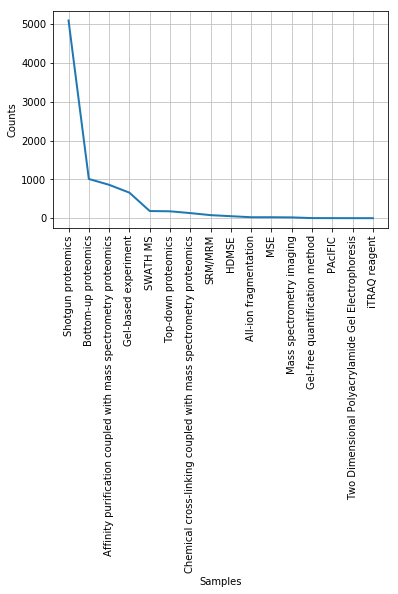

In [61]:
print("Num projects unlabeled: " + str(df[~df.experimentTypes.apply(lambda x: len(x) > 0)].shape[0]))
print("Num unique: " + str(len(pd.unique([item for sublist in df.experimentTypes for item in sublist]))))
pprint.pprint(pd.unique([item for sublist in df.experimentTypes for item in sublist]))
freq = nltk.FreqDist([item for sublist in df.experimentTypes for item in sublist])

freq.plot(20, cumulative=False)

## instrumentNames

Num projects unlabeled: 0
Num unique: 129
array(['Q Exactive', 'LTQ Orbitrap Elite', 'LTQ Orbitrap',
       'Orbitrap Fusion Lumos', 'LTQ Orbitrap Velos', 'Q Exactive HF',
       'Orbitrap Fusion', 'LTQ', 'TripleTOF 5600', 'LTQ Orbitrap XL',
       'Synapt G2 MS', 'Synapt MS', 'Q-Tof Premier', 'ultraflex TOF/TOF',
       '6520 Quadrupole Time-of-Flight LC/MS', 'ultraflex', 'LTQ FT',
       'TripleTOF 5600+', 'liquid chromatography separation',
       'Orbitrap Fusion ETD', '6410 Triple Quadrupole LC/MS',
       'Q Exactive Plus', 'maXis', 'TSQ Vantage', 'QSTAR',
       'Q Exactive HF-X', 'Bruker Daltonics instrument model',
       'Q-Tof ultima', 'Bruker Daltonics micrOTOF series',
       'Thermo Scientific', 'autoflex', 'Agilent instrument model',
       '6220 Time-of-Flight LC/MS', 'AB SCIEX instrument model',
       '4800 Proteomics Analyzer', 'Bruker Daltonics maXis series',
       'apex ultra', 'Synapt G2-S HDMS', 'Synapt HDMS', 'maXis 4G',
       'LTQ Velos', 'LTQ Orbitap Discove

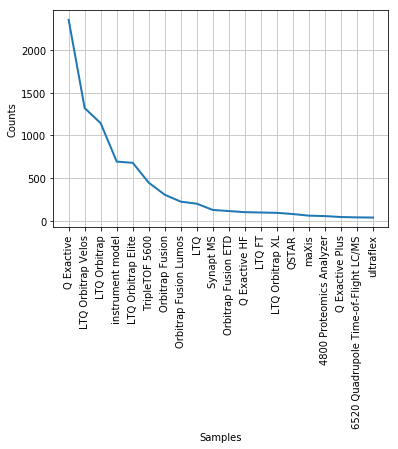

In [62]:
print("Num projects unlabeled: " + str(df[~df.instrumentNames.apply(lambda x: len(x) > 0)].shape[0]))
print("Num unique: " + str(len(pd.unique([item for sublist in df.instrumentNames for item in sublist]))))
pprint.pprint(pd.unique([item for sublist in df.instrumentNames for item in sublist]))
freq = nltk.FreqDist([item for sublist in df.instrumentNames for item in sublist])

freq.plot(20, cumulative=False)

## keywords

Num projects unlabeled: 0
Num unique: 14214
array(['neutrophils', 'antifungal extracellular vesicles',
       'Aspergillus fumigatus', ...,
       'human umbilical vein endothelial cells (HUVECs)',
       'primary human osteoblasts (hOBs)',
       'stable isotope labeling by amino acids in cell culture (SILAC)'], dtype=object)


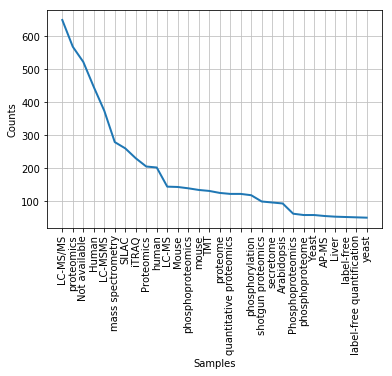

In [79]:
#df_keywords = df.keywords.apply(lambda x: list(map(lambda x: x.strip(), x.split(','))))
df_keywords = df.keywords.apply(lambda x: list(map(lambda x: x.strip(), x.replace(';', ',').replace(' / ', ',').split(','))))
print("Num projects unlabeled: " + str(df[df_keywords.apply(lambda x: set(x) == set(['']))].shape[0]))
print("Num unique: " + str(len(pd.unique([item for sublist in df_keywords for item in sublist]))))
pprint.pprint(pd.unique([item for sublist in df_keywords for item in sublist]))
freq = nltk.FreqDist([item for sublist in df_keywords for item in sublist])

freq.plot(30, cumulative=False)

## numAssays

In [12]:
df[df.numAssays != 0].shape

(2052, 28)

[]

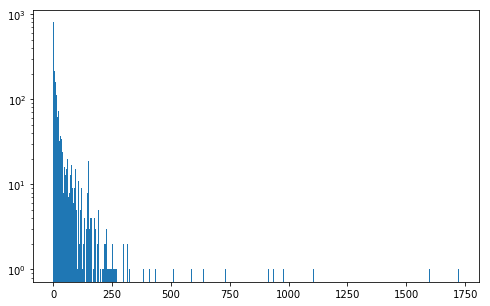

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.hist(df[df.numAssays != 0].numAssays, bins='auto', log=True)
plt.plot()

## numSpectra

In [14]:
df[df.numSpectra != 0].shape

(1977, 28)

[]

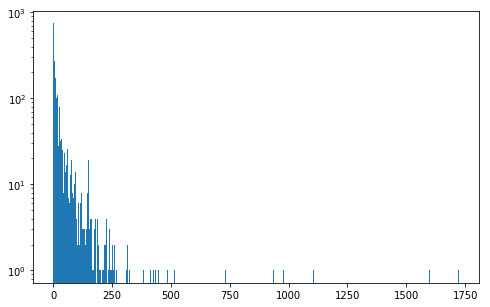

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.hist(df[df.numSpectra != 0].numAssays, bins='auto', log=True)
plt.plot()

## numPeptides

In [16]:
df[df.numPeptides != 0].shape

(1933, 28)

[]

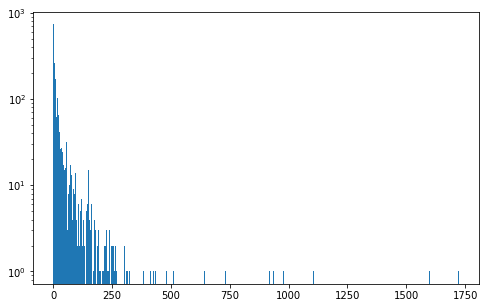

In [17]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.hist(df[df.numPeptides != 0].numAssays, bins='auto', log=True)
plt.plot()

In [18]:
df[~df.otherOmicsLink.isna()]

,accession,dataProcessingProtocol,doi,experimentTypes,instrumentNames,keywords,labHeads,numAssays,numIdentifiedSpectra,numPeptides,numProteins,numSpectra,numUniquePeptides,otherOmicsLink,projectDescription,projectTags,ptmNames,publicationDate,quantificationMethods,reanalysis,references,sampleProcessingProtocol,species,submissionDate,submissionType,submitter,tissues,title
1021,PXD007599,All spectra (.raw files) generated from MS wer...,None,[Shotgun proteomics],[LTQ Orbitrap],"carnivorous, enzymes, LC-MS, Nepenthes, orbitr...","[{'title': 'Dr', 'firstName': 'HOE-HAN', 'last...",0,0,0,0,0,0,http://www.ncbi.nlm.nih.gov/sra/SRX2692198. ht...,"Pitcher fluids from 3 species of Nepenthes, na...",[Biological],[iodoacetamide derivatized residue],2018-11-29,[],None,[],Collected pitcher fluids were filtered through...,"[Nepenthes ampullaria, Nepenthes rafflesiana, ...",2018-11-28,PARTIAL,"{'title': 'Dr', 'firstName': 'Hoe-Han', 'lastN...",[pitcher secretion],Pitcher fluid protein profiling from Nepenthes...
1031,PXD011187,All raw data files from Xcalibur software were...,None,[Shotgun proteomics],"[LTQ Orbitrap Elite, Q Exactive]","Phosphoproteome,ALK inhibition,neuroblastoma,o...","[{'title': 'Dr', 'firstName': 'Bengt', 'lastNa...",0,0,0,0,0,0,E-MTAB-6654,Neuroblastoma is a neural crest-derived embryo...,[Biomedical],"[iodoacetamide derivatized residue, phosphoryl...",2018-11-27,[Normalized Spectral Abundance Factor - NSAF],None,"[{'desc': 'Van den Eynden J, Umapathy G, Ashou...",Tyrosine/serine/threonine profiling was perfor...,[Homo sapiens (Human)],2018-09-25,PARTIAL,"{'title': 'Dr', 'firstName': 'Vicky', 'lastNam...","[brain, bone marrow]",Phosphoproteome and gene expression profiling ...
1059,PXD009332,Spectra data were acquired in MS and MS/MS mod...,10.6019/PXD009332,[Gel-based experiment],[ultraflex TOF/TOF],"Histomonas meleagridis, protozoa, comparative ...","[{'title': 'Dr', 'firstName': 'Dr. Ivana', 'la...",42,0,198,56,199,171,The current dataset can be linked to the publi...,The current work aimed to detect and identify ...,[Biomedical],"[Carbamidomethyl, Oxidation, Gln->pyro-Glu, De...",2018-11-22,[],None,"[{'desc': 'Monoyios A, Hummel K, Nöbauer K, Pa...",Significantly differentially abundant protein ...,[Histomonas meleagridis],2018-03-26,COMPLETE,"{'title': 'Dr', 'firstName': 'Ivana', 'lastNam...",[cell culture],An alliance of gel-based and gel-free proteomi...
108,PXD012225,Peptide spectral matching was performed with M...,10.6019/PXD012225,[Chemical cross-linking coupled with mass spec...,"[Orbitrap Fusion Lumos, Q Exactive]","Fibrin, Clot, ECM, insoluble protein, matrix, ...","[{'title': 'Dr', 'firstName': 'Kirk C', 'lastN...",3,0,732569,22837,682462,115031,https://www.yeastrc.org/proxl_public/viewProje...,Here we present characterization of fibrin clo...,[Technical],"[Carbamidomethyl, Cys->Dha, Oxidation, Trioxid...",2019-04-26,[],None,[],"For development, human blood from a healthy do...",[Homo sapiens (Human)],2019-01-03,COMPLETE,"{'title': 'Dr', 'firstName': 'Kirk ', 'lastNam...","[blood plasma, blood]",Molecular Mapping of FXIIIa Crosslinks
1095,PXD007154,Raw data of all experiments except histone PTM...,None,[Affinity purification coupled with mass spect...,"[Synapt MS, Orbitrap Fusion, Q Exactive]","Chromatin profiling, mouse embryonic stem cell...","[{'title': 'Dr', 'firstName': 'Hendrik', 'last...",0,0,0,0,0,0,GSE101675,The ground state of pluripotency is defined as...,[Biological],"[formylated residue, dimethylated residue, N6-...",2018-11-21,[],None,[],"For whole cell proteomes, cells were lysed in ...",[Mus musculus (Mouse)],2017-08-09,PARTIAL,"{'title': 'Mr', 'firstName': 'Guido', 'lastNam...",[],Integrative proteomics reveals a protective ro...
1098,PXD007133,Peptide samples were analyzed by reverse-phase...,None,[Affinity purification coupled with mass spect...,[Q Exactive],"Pseudomonas putida KT2440, pCAR1, SILAC, LC-MSMS","[{'title': 'Dr', 'firstName': 'Saori', 'lastNa...",0,0,0,0,0,0,PXD007089,"The i

In [19]:
df[~df.otherOmicsLink.isna()].shape

(234, 28)

## projectDescription

In [20]:
df[~df.projectDescription.isna()].shape

(7580, 28)

Let's skip the NLP processing for now and finish reviewing our numerical and categorical data

## projectTags

Num projects unlabeled: 1257
Num unique: 34
array(['Biological', 'Biomedical', 'Technical',
       'Glycoproteomics (B/D-HPP)', 'Metaproteomics',
       'Biology/Disease-Driven Human Proteome Project (B/D-HPP)',
       'Human Proteome Project',
       'Human Brain Proteome Project (HUPO_HBPP) (B/D-HPP)',
       'Liver (B/D-HPP)',
       'Chromosome-centric Human Proteome Project (C-HPP)',
       'Cancer (B/D-HPP)', 'CPTAC Consortium',
       'Protein Misfolding and Aggregation (B/D-HPP)',
       'China Human Proteome Project (CNHPP)',
       'Epigenetic Chromatin (B/D-HPP)',
       'Skeletal Muscle Proteome (B/D-HPP)',
       'Malaria Host-Pathogen Interaction Center (MaHPIC)',
       'PRIME-XS Project', 'Cardiovascular (B/D-HPP)',
       'Diabetes (B/D-HPP)', 'ProteomeTools', 'Reference',
       'EyeOME (B/D-HPP)', 'Food and Nutrition (B/D-HPP)',
       'Kidney Urine (B/D-HPP)',
       'Bioinformatics Infrastructure for Life Sciences (BILS) network (Sweden)',
       'Extreme Condition

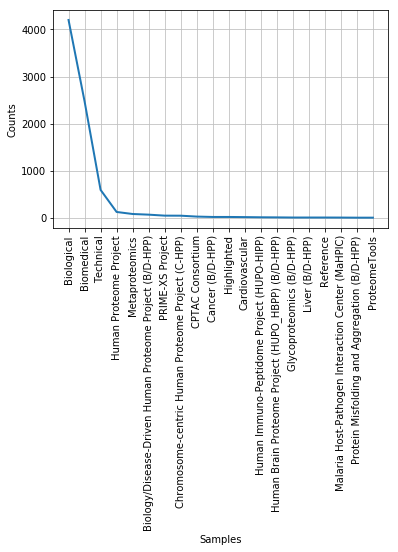

In [57]:
print("Num projects unlabeled: " + str(df[~df.projectTags.apply(lambda x: len(x) > 0)].shape[0]))
print("Num unique: " + str(len(pd.unique([item for sublist in df.projectTags for item in sublist]))))
pprint.pprint(pd.unique([item for sublist in df.projectTags for item in sublist]))
freq = nltk.FreqDist([item for sublist in df.projectTags for item in sublist])

freq.plot(20, cumulative=False)

## ptmNames

Num unique: 1195
array(['iodoacetamide derivatized residue',
       'TMT6plex-126 reporter+balance reagent acylated residue',
       'monohydroxylated residue', ..., 'Iodoacetamide derivative',
       'S-cyano-L-cysteine', 'Dehydro'], dtype=object)


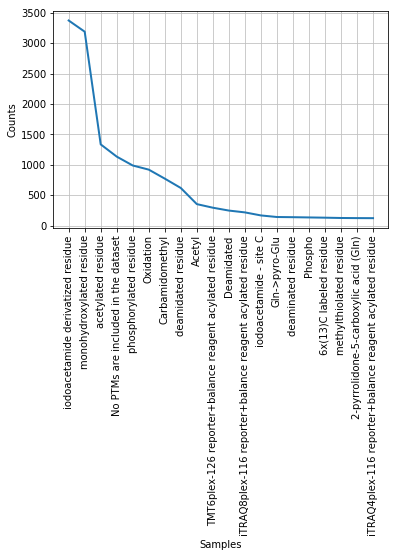

In [22]:
print("Num unique: " + str(len(pd.unique([item for sublist in df.ptmNames for item in sublist]))))
pprint.pprint(pd.unique([item for sublist in df.ptmNames for item in sublist]))
freq = nltk.FreqDist([item for sublist in df.ptmNames for item in sublist])

freq.plot(20, cumulative=False)

## publicationDate

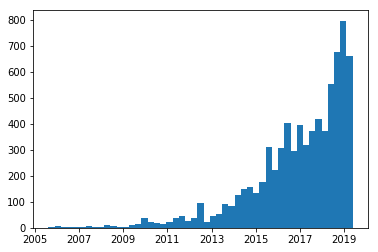

We add a plot binned to the month so that we can have an idea of the monthly publication rate:


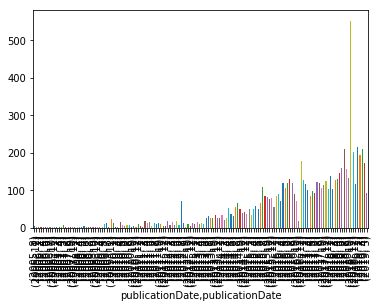

In [33]:
df.publicationDate = df.publicationDate.astype("datetime64")
plt.hist(df.publicationDate, bins='auto')
plt.show()

print("We add a plot binned to the month so that we can have an idea of the monthly publication rate:")
df.publicationDate.groupby([df.publicationDate.dt.year, df.publicationDate.dt.month]).count().plot(kind="bar")
plt.show()

## quantificationMethods

Num projects unlabeled: 3966
Num unique: 63
['TMT' 'Label free' 'Peptide counting'
 'MS1 intensity based label-free quantification method' 'Spectrum counting'
 'SILAC' 'Variable modification' 'Peptide mass tolerance setting'
 'Identified by peptide fragmentation' 'Peptide selection'
 'Peptide search engine output parameter' 'Data-independent acquisition'
 'Normalized Spectral Abundance Factor - NSAF' 'TIC'
 'Protein Abundance Index - PAI' 'Spectrum count/molecular weight'
 'Parallel Reaction Monitoring (PRM)' 'iTRAQ'
 'APEX - Absolute Protein Expression' 'emPAI' 'AQUA' 'SWATH MS'
 'Isotope labeling' 'Spectral Abundance Factor - SAF' 'precursor ion'
 'MS1 based isotope labeling' 'Gel spot volume'
 'Gel-based quantification method' 'Heavy stable isotope label' 'ICAT'
 'Stable isotope ratio' 'Gel-free quantification method'
 'Mass spectrometry' 'All peptides matched' 'Absolute quantification unit'
 'LC-MS label-free quantitation analysis' 'Mascot score' 'MSE' '18O'
 'HDMSE' 'Relative quan

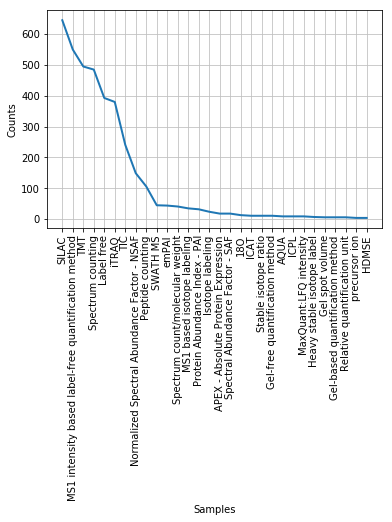

In [56]:
print("Num projects unlabeled: " + str(df[~df.quantificationMethods.apply(lambda x: len(x) > 0)].shape[0]))
print("Num unique: " + str(len(pd.unique([item for sublist in df.quantificationMethods for item in sublist]))))
print(pd.unique([item for sublist in df.quantificationMethods for item in sublist])[:50])
freq = nltk.FreqDist([item for sublist in df.quantificationMethods for item in sublist])

freq.plot(30, cumulative=False)

## species

Num projects unlabeled: 15
Num unique: 1527
['Neosartorya fumigata (Aspergillus fumigatus)' 'Pseudotsuga menziesii'
 'Mus musculus (Mouse)' "Saccharomyces cerevisiae (Baker's yeast)"
 'Bacillus subtilis subsp. subtilis str. NCIB 3610' 'Homo sapiens (Human)'
 'Microbacterium sp.' 'Leishmania donovani' 'Camellia sinensis'
 'uncultured soil bacterium S0137' 'Fasciola hepatica (Liver fluke)'
 'Staphylococcus haemolyticus' 'Cyanea capillata' 'Nemopilema nomurai'
 'Drosophila melanogaster (Fruit fly)' 'Ctenopharyngodon idella'
 'Nepenthes ampullaria' 'Nepenthes rafflesiana' 'Nepenthes x hookeriana'
 'Rattus norvegicus (Rat)']


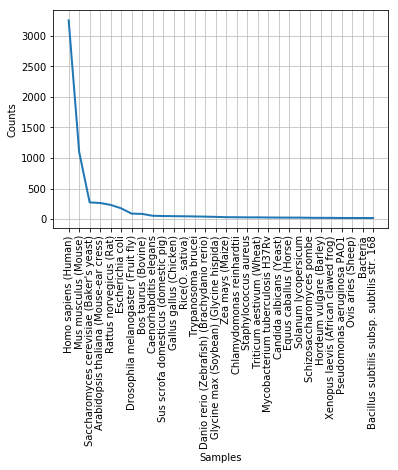

Num species == 1: 6976
Num species > 1: 595


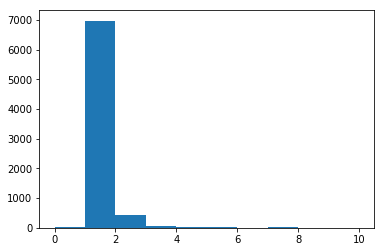

In [91]:
print("Num projects unlabeled: " + str(df[~df.species.apply(lambda x: len(x) > 0)].shape[0]))
print("Num unique: " + str(len(pd.unique([item for sublist in df.species for item in sublist]))))
print(pd.unique([item for sublist in df.species for item in sublist])[:20])
freq = nltk.FreqDist([item for sublist in df.species for item in sublist])

freq.plot(30, cumulative=False)
plt.hist(df.species.apply(lambda x: len(x)), bins=list(range(0,11)), cumulative=False)
print("Num species == 1: {}".format(df[df.species.apply(lambda x: len(x) == 1)].shape[0]))
print("Num species > 1: {}".format(df[df.species.apply(lambda x: len(x) > 1)].shape[0]))

## tissues

Num projects unlabeled: 2770
Num unique: 640
['embryo' 'brain' 'urinary bladder' 'cell culture' 'JURKAT cell'
 'blood plasma' 'leaf' 'cerebrospinal fluid' 'nematocyst' 'trophoblast'
 'oocyte' 'Egg' 'tooth enamel' 'urine' 'pitcher secretion' 'lung'
 'bone marrow' 'mycelium' 'spleen' 'lymph node' 'blood serum' 'kidney'
 'skin' 'dental plaque' 'whole plant' 'whole body' 'gastric epithelium'
 'blood platelet' 'blood' 'erythrocyte' 'HeLa cell' 'cell lysate' 'liver'
 'heart' 'retinal pigment epithelium cell' 'colon' 'midgut'
 'haematopoietic stem cells' 'thymus' 'small intestine' 'prostate gland'
 'gut' 'thyroid gland' 'stomach' 'longissimus' 'testis' 'lymph' 'uterus'
 'retina' 'pancreas']


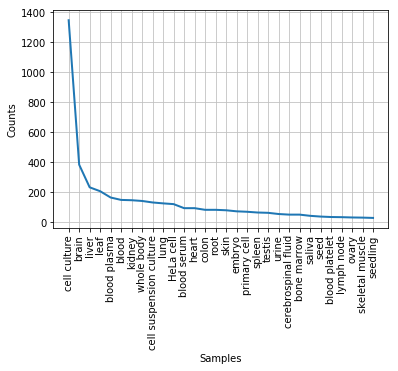

In [54]:
print("Num projects unlabeled: " + str(df[~df.tissues.apply(lambda x: len(x) > 0)].shape[0]))
print("Num unique: " + str(len(pd.unique([item for sublist in df.tissues for item in sublist]))))
print(pd.unique([item for sublist in df.tissues for item in sublist])[:50])
freq = nltk.FreqDist([item for sublist in df.tissues for item in sublist])

freq.plot(30, cumulative=False)

## What can we try?

Understanding which species an experiment contains is something that we're trying to do using Param-Medic and short runs of the Tide peptide search tool. Basically, this takes a raw experiment file and tries to infer which species that experiment contains by trying to query it with the genome of each species and seeing which performs the best. Tide produces a series of peptide detections, and we expect that searching with the correct species type will produce the most detections. However, this can't handle experiments with mixtures of species. Another issue is that similar species like mouse and rat can be confused. And each tide search is expensive. Maybe an NLP classification could help distinguish between single and multi-species experiments. Then we could flag the complex experiments for manual insepction. Or we could get fancy and try performing a multi-target classification to fully automate species selection.

# Training

In [125]:
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

Let's try using the descriptions to do a simple binary classification of mixture vs non-mixture.

In [126]:
df = pd.read_json("raw/PRIDE_projects.json")

In [127]:
# Trim out unlabeled data
print("Trimming out {} rows without species labels".format(df[df.species.apply(lambda x: len(x) == 0)].shape[0]))
df = df[df.species.apply(lambda x: len(x) > 0)]

Trimming out 15 rows without species labels


In [128]:
df['multiSpecies'] = df.species.apply(lambda x: len(x) > 1)

In [129]:
# Combine the descriptive texts into one
#df['fullDescription'] = df.apply
df["text"] = df.apply(lambda row: '{}\n{}\n{}'.format(row['projectDescription'], row['sampleProcessingProtocol'], row['dataProcessingProtocol']), axis=1)

In [130]:
train = df[["text", "multiSpecies"]]
train.head()

,text,multiSpecies
0,Neutrophil-derived extracellular vesicles have...,False
1,Objectives: to characterize and to better unde...,False
10,"Abstract Here we present IPSA, an innovative w...",True
100,Biofilms are structured communities of tigh...,False
1000,A quantitative label-free proteome analysis of...,False


In [134]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(train.multiSpecies.values)

In [156]:
print(y[:5])

[0 0 1 0 0]


In [135]:
xtrain, xtest, ytrain, ytest = train_test_split(train.text.values,
                                                y, 
                                                stratify=y,
                                                random_state=1, 
                                                test_size=0.1,
                                                shuffle=True)

xtrain, xvalid, ytrain, yvalid = train_test_split(xtrain,
                                                  ytrain, 
                                                  stratify=ytrain,
                                                  random_state=3, 
                                                  test_size=0.1,
                                                  shuffle=True)

In [136]:
print(xtrain.shape)
print(xvalid.shape)
print(xtest.shape)

(6131,)
(682,)
(758,)


In [197]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [137]:
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)

In [139]:
# Fitting a simple Logistic Regression on TFIDF
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


logloss: 0.263 


In [140]:
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(xtrain) + list(xvalid))
xtrain_ctv =  ctv.transform(xtrain) 
xvalid_ctv = ctv.transform(xvalid)

In [141]:
# Fitting a simple Logistic Regression on Counts
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict_proba(xvalid_ctv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.442 


In [175]:
# Fitting a simple Naive Bayes on TFIDF
clf = MultinomialNB()
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))
print ("logloss: %0.3f " % metrics.log_loss(yvalid, predictions))


logloss: 0.997 
logloss: 0.997 


In [143]:
# Fitting a simple Naive Bayes on Counts
clf = MultinomialNB()
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict_proba(xvalid_ctv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 2.800 


In [144]:
# Apply SVD, I chose 120 components. 120-200 components are good enough for SVM model.
svd = decomposition.TruncatedSVD(n_components=120)
svd.fit(xtrain_tfv)
xtrain_svd = svd.transform(xtrain_tfv)
xvalid_svd = svd.transform(xvalid_tfv)

# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
scl = preprocessing.StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)
xvalid_svd_scl = scl.transform(xvalid_svd)

In [145]:
# Fitting a simple SVM
clf = SVC(C=1.0, probability=True) # since we need probabilities
clf.fit(xtrain_svd_scl, ytrain)
predictions = clf.predict_proba(xvalid_svd_scl)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.295 


In [146]:
# Fitting a simple xgboost on tf-idf
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_tfv.tocsc(), ytrain)
predictions = clf.predict_proba(xvalid_tfv.tocsc())

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.287 


In [198]:
# Fitting a simple xgboost on count vectorizer
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_ctv.tocsc(), ytrain)
predictions = clf.predict_proba(xvalid_ctv.tocsc())

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

KeyboardInterrupt: 

In [148]:
# Fitting a simple xgboost on tf-idf svd features
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_svd, ytrain)
predictions = clf.predict_proba(xvalid_svd)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.334 


In [149]:
# Fitting a simple xgboost on tf-idf svd features
clf = xgb.XGBClassifier(nthread=10)
clf.fit(xtrain_svd, ytrain)
predictions = clf.predict_proba(xvalid_svd)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.267 


In [176]:
ll_scorer = metrics.make_scorer(metrics.log_loss, greater_is_better=False, needs_proba=True)

In [183]:
# Initialize SVD
svd = TruncatedSVD()
    
# Initialize the standard scaler 
scl = preprocessing.StandardScaler()

# We will use logistic regression here..
lr_model = LogisticRegression()

# Create the pipeline 
clf = pipeline.Pipeline([('svd', svd),
                         ('scl', scl),
                         ('lr', lr_model)])

In [184]:
param_grid = {'svd__n_components' : [120, 180],
              'lr__C': [0.1, 1.0, 10], 
              'lr__penalty': ['l1', 'l2']}

In [185]:
# Initialize Grid Search Model
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=mll_scorer,
                                 verbose=10, n_jobs=-1, iid=True, refit=True, cv=2)

# Fit Grid Search Model
model.fit(xtrain_tfv, ytrain)  # we can use the full data here but I'm only using xtrain
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   2 out of  24 | elapsed:  1.3min remaining: 14.1min
[Parallel(n_jobs=-1)]: Done   5 out of  24 | elapsed:  1.3min remaining:  5.0min
[Parallel(n_jobs=-1)]: Done   8 out of  24 | elapsed:  1.3min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done  11 out of  24 | elapsed:  2.0min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:  2.0min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  17 out of  24 | elapsed:  2.4min remaining:   58.8s
[Parallel(n_jobs=-1)]: Done  20 out of  24 | elapsed:  2.4min remaining:   29.2s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  2.7min finished


Best score: -0.191
Best parameters set:
	lr__C: 0.1
	lr__penalty: 'l2'
	svd__n_components: 120


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [180]:
nb_model = MultinomialNB()

# Create the pipeline 
clf = pipeline.Pipeline([('nb', nb_model)])

# parameter grid
param_grid = {'nb__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Initialize Grid Search Model
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=ll_scorer,
                                 verbose=10, n_jobs=-1, iid=True, refit=True, cv=2)

# Fit Grid Search Model
model.fit(xtrain_tfv, ytrain)  # we can use the full data here but im only using xtrain. 
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 2 folds for each of 6 candidates, totalling 12 fits
Best score: -0.284
Best parameters set:
	nb__alpha: 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.3s finished


In [154]:
# Download GloVe vectors dictionary
import urllib.request

url = 'http://www-nlp.stanford.edu/data/glove.840B.300d.zip'
urllib.request.urlretrieve(url, 'raw/glove.840B.300d.zip')

import zipfile
zip_ref = zipfile.ZipFile('raw/glove.840B.300d.zip', 'r')
zip_ref.extractall('raw')
zip_ref.close()

In [169]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('raw/glove.840B.300d.txt')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


0it [00:00, ?it/s]
1724it [00:00, 17230.44it/s]
3442it [00:00, 17214.74it/s]
5165it [00:00, 17219.05it/s]
6892it [00:00, 17233.96it/s]
8624it [00:00, 17258.29it/s]
10358it [00:00, 17280.61it/s]
12086it [00:00, 17279.40it/s]
13822it [00:00, 17302.04it/s]
15555it [00:00, 17307.88it/s]
17288it [00:01, 17311.75it/s]
19023it [00:01, 17320.61it/s]
20751it [00:01, 17306.08it/s]
22481it [00:01, 17302.97it/s]
24218it [00:01, 17321.83it/s]
25955it [00:01, 17335.64it/s]
27689it [00:01, 17334.40it/s]
29427it [00:01, 17345.83it/s]
31164it [00:01, 17351.02it/s]
32897it [00:01, 17343.46it/s]
34634it [00:02, 17350.61it/s]
36373it [00:02, 17359.73it/s]
38109it [00:02, 17348.38it/s]
39848it [00:02, 17357.72it/s]
41585it [00:02, 17359.31it/s]
43322it [00:02, 17361.05it/s]
45058it [00:02, 17322.07it/s]
46796it [00:02, 17339.21it/s]
48537it [00:02, 17357.21it/s]
50281it [00:02, 17380.73it/s]
52023it [00:03, 17390.55it/s]

ValueError: could not convert string to float: '.'

In [167]:
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    words = str(s).lower().decode('utf-8')
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [168]:
# create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec(x) for x in tqdm(xtrain)]
xvalid_glove = [sent2vec(x) for x in tqdm(xvalid)]

  0%|          | 0/6131 [00:00<?, ?it/s]

AttributeError: 'str' object has no attribute 'decode'

In [ ]:
xtrain_glove = np.array(xtrain_glove)
xvalid_glove = np.array(xvalid_glove)

In [ ]:
# Fitting a simple xgboost on glove features
clf = xgb.XGBClassifier(nthread=10, silent=False)
clf.fit(xtrain_glove, ytrain)
predictions = clf.predict_proba(xvalid_glove)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

In [ ]:
# Fitting a simple xgboost on glove features
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1, silent=False)
clf.fit(xtrain_glove, ytrain)
predictions = clf.predict_proba(xvalid_glove)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

## Test set evaluation

In [200]:
xtest_tfv = tfv.transform(xtest)
xtest_ctv = ctv.transform(xtest)

In [203]:
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_ctv.tocsc(), ytrain)

predictions = clf.predict_proba(xtrain_ctv.tocsc())
print ("logloss: %0.3f " % metrics.log_loss(ytrain, predictions))

predictions = clf.predict_proba(xvalid_ctv.tocsc())
print ("logloss: %0.3f " % metrics.log_loss(yvalid, predictions))

logloss: 0.046 
logloss: 0.280 


In [223]:
predictions = clf.predict_proba(xtest_ctv.tocsc())
print ("logloss: %0.3f " % metrics.log_loss(ytest, predictions))
print([i for i in (predictions[:5] > 0.5)[:, 1]])
print(ytest[:5])
print ("accuracy: %0.3f " % metrics.accuracy_score(ytest, [i for i in (predictions > 0.5)[:, 1]]))

logloss: 0.262 
[False, False, False, False, False]
[0 0 0 0 0]
accuracy: 0.923 


In [ ]:
#predictions = model.predict(xtrain_tfv)
#print ("logloss: %0.3f " % metrics.log_loss(ytrain, predictions))

#predictions = model.predict(xvalid_tfv)
#print ("logloss: %0.3f " % metrics.log_loss(yvalid, predictions))

#predictions = model.predict(xtest_tfv)
#print ("logloss: %0.3f " % metrics.log_loss(ytest, predictions))